## Import Libraries

In [ ]:
# Import necessary libraries for data handling, computation, visualization, and clustering

import pandas as pd, numpy as np, matplotlib.pyplot as plt
import utm
import matplotlib.ticker as ticker
from itertools import groupby
import os, os.path
import seaborn as sns
from datetime import datetime
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score

## Entropy Calculation Function

In [2]:
# Define a function to calculate entropy based on location frequency
def calculate_entropy(freq):
    # Initialize probability list and calculate the sum of all frequencies
    Probabilities = []
    sum_of_all_freq = sum(freq)

    # Calculate the probability for each location
    for count in freq:
        Prob = count / sum_of_all_freq
        Probabilities.append(Prob)
    
    # Compute entropy using the probability distribution
    entropy_of_loc = -np.sum(Probabilities * np.log2(Probabilities))
    return entropy_of_loc

## Load Dataset

In [3]:
# Load the GPS trajectory data for a specific user (User_087)
# This dataset includes 'Latitude', 'Longitude', and 'Time' columns for each data point
df = pd.read_csv('User_087_latlontime.csv', encoding='utf-8')
df = df.iloc[: , 1:] # Assuming the first column is an index column to be removed
df.head()

,Latitude,Longitude,Time
0,4.425974e+06,442819.372178,0.628333
1,4.425974e+06,442798.026394,0.634722
2,4.425973e+06,442773.820599,0.638611
3,4.425969e+06,442748.177829,0.643611
4,4.425956e+06,442715.350168,0.650556


## Data Preprocessing

In [4]:
coords = df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = df['Time'].values.tolist()

In [5]:
total_points = len(coords)
print('Total points: ',len(coords))

Total points:  144


In [6]:
#Finding minimum and maximum points from user data
lats_index_min = np.argmin(lats_xy)
lats_index_max = np.argmax(lats_xy)
longs_index_min = np.argmin(longs_xy)
longs_index_max = np.argmax(longs_xy)

#Defining the boundary points
p1_xy = (longs_xy[longs_index_min],lats_xy[lats_index_min])
p2_xy = (longs_xy[longs_index_min],lats_xy[lats_index_max])
p3_xy = (longs_xy[longs_index_max],lats_xy[lats_index_min])
p4_xy = (longs_xy[longs_index_max],lats_xy[lats_index_max])

### Mapping of points in a 3D space-time grid and calculate entropy after addition of each new point

In [7]:
X = np.linspace((longs_xy[longs_index_min]),(longs_xy[longs_index_max]),10)
Y = np.linspace((lats_xy[lats_index_min]),(lats_xy[lats_index_max]), 10)
Z = np.linspace(0,24,24)
d=1
grids_index = np.zeros((10,10,24))
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
allover_entropy=[]

for t in range(24):
    for yax in range(10):
        for xax in range(10):
            grids_index[xax,yax,t]=d
            d=d+1
            

for user in range(len(coords)):
    p_lat = lats_xy[user]
    p_long = longs_xy[user]
    p_time = user_time[user]
    for t in range(24):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(10):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(10):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            found_grid_index.append(int(found_at))
    frequency_of_grids = [len(list(group)) for key, group in groupby(found_grid_index)]
    current_entropy = calculate_entropy(frequency_of_grids)
    allover_entropy.append(current_entropy)

### Normalizing the data points

In [8]:
scaler = MinMaxScaler()
model=scaler.fit(df)
scaled_data=model.transform(df)
normalized_data = pd.DataFrame(scaled_data, columns = ['Latitude','Longitude','Time'])

### Plot raw normalized data points

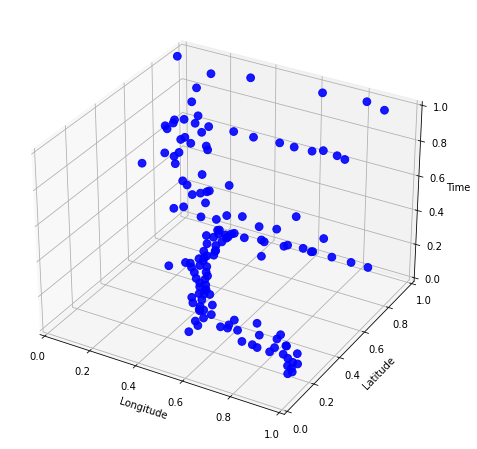

In [9]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(normalized_data['Longitude'], normalized_data['Latitude'], normalized_data['Time'],color='blue',alpha=0.9, s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')
plt.show()

In [10]:
min_pts = (5/100)*len(lats_xy)
epsilon = 0.1

### Clustering of raw normalized data

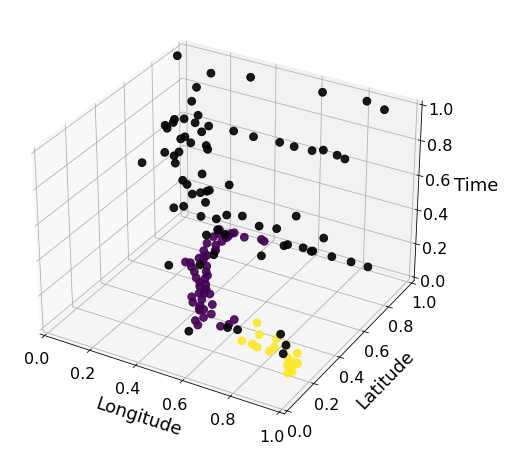

In [11]:
db = DBSCAN(eps=epsilon, min_samples=min_pts, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=4, frameon=True)
#plt.gca().add_artist(first_legend)
#plt.legend(loc='upper left')
plt.show()

In [12]:
#Computing "the Silhouette Score"
#print("Silhouette Coefficient: %0.3f"
 #     % metrics.silhouette_score(normalized_data, db.labels_))

In [13]:
#print(davies_bouldin_score(normalized_data, db.labels_))

In [14]:
# get the number of clusters
num_clusters_all = len(set(db.labels_))
print(num_clusters_all)

3


### Find points that can be transmitted directly

In [15]:
threshold = 1
delta_1 = 10/100

In [16]:
max_limit = (threshold/100)*len(coords) 
new_data = []
scaled_points = []
for temp in range(len(allover_entropy)-1):
    if allover_entropy[temp] != 0:
        percent_change = ((allover_entropy[temp+1]-allover_entropy[temp])/allover_entropy[temp])*100
        if percent_change > delta_1:
            new_data.append(df.iloc[temp].tolist())
            scaled_points.append(scaled_data[temp].tolist())

In [17]:
direct_points = len(new_data)
print('Directly transmitted points: ',len(new_data))

Directly transmitted points:  117


In [18]:
new_df = pd.DataFrame(new_data, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(scaled_points, columns = ['Latitude','Longitude','Time'])

In [19]:
coords = new_df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = new_df['Time'].values.tolist()
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
d=1
new_points = []
new_scaled_points = []

In [20]:
# Store maximum of 1% points in a grid
for user in range(len(coords)):
    p_lat = lats_xy[user]
    p_long = longs_xy[user]
    p_time = user_time[user]
    for t in range(24):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(10):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(10):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            point_count_inside_grid[:,int(found_at)] += 1
                            if point_count_inside_grid[:,int(found_at)] <= max_limit:
                                new_points.append(new_df.iloc[user].tolist())
                                new_scaled_points.append(normalized_data.iloc[user].tolist())

In [21]:
new_df = pd.DataFrame(new_points, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(new_scaled_points, columns = ['Latitude','Longitude','Time'])

### Plot directly transmitted normalized data points

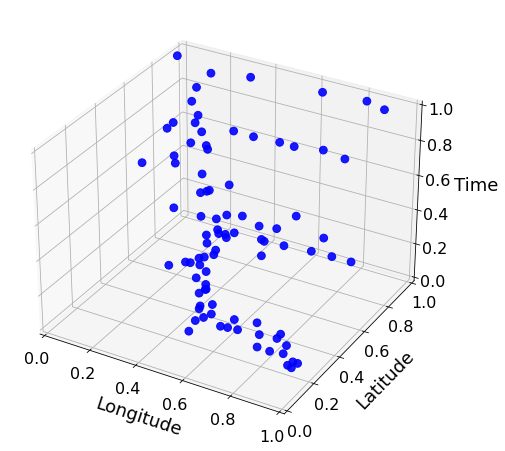

In [22]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(normalized_data['Longitude'], normalized_data['Latitude'], normalized_data['Time'],color='blue',alpha=0.9, s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
plt.show()

### Clustering of directly transmitted data points

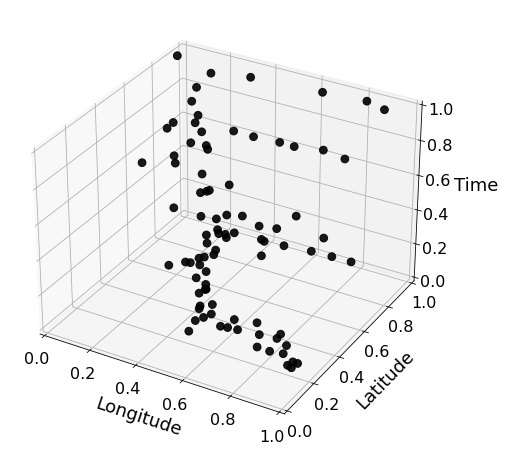

In [23]:
db = DBSCAN(eps=epsilon, min_samples=min_pts, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(loc='upper left')
#plt.gca().add_artist(first_legend)
#plt.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=5, frameon=True)
plt.show()

In [24]:
#Computing "the Silhouette Score"
'''
try:
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, db.labels_))
except ValueError:
    num_clusters = 1
    percent_clusters = ((num_clusters_all - num_clusters)/num_clusters_all)*100
    percent_points = ((total_points - direct_points)/total_points)*100
    
    new_data = [[delta_1*100, epsilon, percent_clusters, percent_points]]
    df = pd.DataFrame(new_data, columns = ['Delta', 'Epsilon', 'Percentage of clusters reduction', 'Percentage of points through SMC'])

    df.to_csv('User 087 surface data scheme 1 without th.csv', mode='a', header=False, index=False)
 '''   

'\ntry:\n    print("Silhouette Coefficient: %0.3f"\n      % metrics.silhouette_score(normalized_data, db.labels_))\nexcept ValueError:\n    num_clusters = 1\n    percent_clusters = ((num_clusters_all - num_clusters)/num_clusters_all)*100\n    percent_points = ((total_points - direct_points)/total_points)*100\n    \n    new_data = [[delta_1*100, epsilon, percent_clusters, percent_points]]\n    df = pd.DataFrame(new_data, columns = [\'Delta\', \'Epsilon\', \'Percentage of clusters reduction\', \'Percentage of points through SMC\'])\n\n    df.to_csv(\'User 087 surface data scheme 1 without th.csv\', mode=\'a\', header=False, index=False)\n '

In [25]:
print(davies_bouldin_score(normalized_data, db.labels_))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
# get the number of clusters
num_clusters = len(set(db.labels_))
print(num_clusters)

In [ ]:
percent_clusters = ((num_clusters_all - num_clusters)/num_clusters_all)*100
percent_points = ((total_points - direct_points)/total_points)*100

In [ ]:
## To write data onto file

#new_data = [[delta_1*100, epsilon, percent_clusters, percent_points]]
#df = pd.DataFrame(new_data, columns = ['Delta', 'Epsilon', 'Percentage of clusters reduction', 'Percentage of points through SMC'])

#df.to_csv('User 087 surface data scheme 1 without th.csv', mode='a', header=False, index=False)